# Обработка прямых многократных измерений по ГОСТ Р 8.736-2011 при малом числе измерений
**Число измерений объемом: 4 $\le$ n $\le$ 15**
### Ссылки на материалы
* [ГОСТ](http://docs.cntd.ru/document/1200089016)
* [Выбросы по критерию Граббса](http://mycroftbs.ru/grabbs/)
* [Исключение систематических погрешностей](http://poznayka.org/s15323t1.html)

### Требования к программному компоненту (ТЗ):
1.	выполнять расчёт и вывод основных характеристик выборки: среднего арифметического значения, оценки среднего квадратического отклонения;
2.	выполнять обработку результатов многократных измерений по заданной методике;
3.	осуществлять вывод результатов необходимых для заданной методики промежуточных расчётов и итоговый результат. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (10,6)
plt.rc('font', family='Arial')

np.random.seed(123)

### Загрузка данных

In [2]:
FILE_PATH = r"data/12_a.txt"

content = ""
with open(FILE_PATH, 'r') as reader:
    for line in reader.readlines():
        content += re.sub(r",", r".", line)
with open(FILE_PATH, 'w') as writer:
    _ = writer.write(content)
df = pd.read_csv(rf"{FILE_PATH}", sep='\n', names=['sample'], dtype=float)

if df.size < 4:
    raise ValueError(f"Lack of samples ({df.size} < 4).")
elif df.size > 15: 
    raise ValueError(f"Too many samples ({df.size} > 15).")
df.T

0      1      2      3     4      5      6      7      8      9   \
sample  6.411  6.349  6.273  6.323  6.23  6.274  6.352  6.277  6.282  6.427   

           10     11    12     13     14  
sample  6.402  6.223  6.36  6.418  6.295

### Загрузка таблиц коэффициентов Граббса и Стьюдента

In [3]:
GRABBS = pd.read_csv(r"app/rsc/grabbs.csv", index_col=0)
STUDENT = pd.read_csv(r"app/rsc/student.csv", index_col=0)
K = pd.read_csv(r"app/rsc/k.csv", index_col=0).values

#### Выбор параметров q и p

In [4]:
Q = 1
P = 95

Gt = None
for i in range(10):
    try:
        Gt = GRABBS.loc[df.size + i, str(Q)]
        break
    except KeyError:
        pass
        
t = None
for i in range(10):
    try:
        t = STUDENT.loc[df.size + i, str(P)]
        break
    except KeyError:
        pass

print(f"Критическое значение критерия Граббса:\t{Gt}\n"
      f"Значение коэффициента Стьюдента t:\t{t}")

Критическое значение критерия Граббса:	2.806
Значение коэффициента Стьюдента t:	2.12


### Алгоритм обработки результатов змерений
**Для прямых многократных независимых измерений**

Под многократными измерениями понимают не менее 4х измерений.

* исключить известные систематические погрешности из результатов измерений;
* вычислить оценку (мат. ожидание / среднее) измеряемой величины;
* вычислить среднее квадратическое отклонение результатов измерений;
* проверить наличие грубых погрешностей и при необходимости исключают их;
* проверить гипотезу о принадлежности результатов измерений нормальному распределению (для случая $\ge$ 15 измерений);
* вычислить доверительные границы случайной погрешности (доверительную случайную погрешность) оценки измеряемой величины;
* вычислить доверительные границы неисключенной систематической погрешности оценки измеряемой величины;
* вычислить доверительные границы погрешности оценки измеряемой величины.

\* *Для определения доверительных границ погрешности оценки измеряемой величины доверительную вероятность принимают равной P = 0,95. В случаях, когда измерение не представляется возможным повторить, помимо границ, соответствующих доверительной вероятности P = 0,95, допускается указывать границы для доверительной вероятности P = 0,99.*

## Выполнение ТЗ1

In [5]:
df_info = df.describe().T
df_info

count    mean       std    min     25%    50%    75%    max
sample   15.0  6.3264  0.067965  6.223  6.2755  6.323  6.381  6.427

#### Вычисление оценки измеряемой величины

In [6]:
x = df.values
x_mean = np.mean(x)
x_std = np.std(x, ddof=1)

print(f"Математическое ожидание измерений:\t{x_mean:.4f}\n"
      f"Среднеквадратическое отклонение:\t{x_std:.4f}")

Математическое ожидание измерений:	6.3264
Среднеквадратическое отклонение:	0.0680


## Выполнение ТЗ2

#### Исключить известные систематические погрешности из результатов измерений
Используя метод введения поправки

In [7]:
SYSTEMATIC_ERROR = []  # ошибка метода, средств измерений, другие источники
a = np.sum(SYSTEMATIC_ERROR)  # где a - систематическая ошибка
y = x - a  # внесение поправки
y_mean = x_mean - a  # внесение поправки в оценку измеряемой величины
y_std = np.std(x, ddof=1.5)  # смещение среднеквадратического отклонения

x_mean_std = x_std / np.sqrt(x.size)  # среднее квадратическое отклонение оценки 
y_mean_std = y_std / np.sqrt(y.size)

print(f"Смещенное математическое ожидание измерений:\t{y_mean:.4f}\t({abs(x_mean - y_mean):.4f})\n"
      f"Смещенное среднеквадратическое отклонение:\t{y_std:.4f}\t({abs(x_std - y_std):.4f})")
print(f"Среднеквадратическое отклонение оценки:\t{x_mean_std:.4f}\n"
      f"Смещенное отклонение среднего значения:\t{y_mean_std:.4f}\t({abs(x_mean_std - y_mean_std):.4f})")

Смещенное математическое ожидание измерений:	6.3264	(0.0000)
Смещенное среднеквадратическое отклонение:	0.0692	(0.0012)
Среднеквадратическое отклонение оценки:	0.0175
Смещенное отклонение среднего значения:	0.0179	(0.0003)


#### Проверка на нормальность
* не требуется при числе измерений n $\le$ 15;
* при n > 15 и n $\le$ 50 используется составной критерий;
* при n > 50 используется критерий Пирсона или омега квадрат (Мизеса-Смирнова).

#### Исключеие грубых погрешностей
С использованием критерия Граббса

In [8]:
y_ = list(y)
G1 = abs(np.max(y_) - y_mean)/y_std
G2 = abs(y_mean - np.min(y_))/y_std

while G1 > Gt or G2 > Gt:
    if G1 > Gt:
        y_.remove(np.max(y_))
    else:
        y_.remove(np.min(y_))
    y_mean = np.mean(y_)
    y_std = np.std(y_, ddof=1.5)
    y_mean_std = y_std / np.sqrt(y_.size)
    G1 = abs(np.max(y_) - y_mean)/y_std
    G2 = abs(y_mean - np.min(y_))/y_std
y = np.array(y_)

print(f"Удалено элементов:\t{y.size - x.size}")

Удалено элементов:	0


#### Доверительные границы случайной погрешности
*Как проверить, является ли выборка распределением Стюьдента или нормальным?*

In [9]:
conf_limits = t*y_mean_std
print(f"Доверительные границы:\t{conf_limits:.4f}")

Доверительные границы:	0.0379


#### Доверительные границы неисключенной систематической погрешности
*Нехватает условия, если НСП появляется в результате исключения систематической погрешности от воздействия влияющей величины Y на измеряемую величину X.*

In [10]:
if len(SYSTEMATIC_ERROR) < 3:
    const_error = np.sum(np.abs(SYSTEMATIC_ERROR))
    systematic_bias = const_error/np.sqrt(3)
else:
    if P == 95:
        k = 1.1
    elif len(SYSTEMATIC_ERROR) > 4:
        k = 1.4
    else:
        l = int(abs(np.max(SYSTEMATIC_ERROR)/np.min(SYSTEMATIC_ERROR)))
        k = float(K[l])  # приблизительное значение
    const_error = k*np.sqrt(np.sum(np.square(SYSTEMATIC_ERROR)))
    systematic_bias = const_error/(k*np.sqrt(3))
    
print(f"Доверительные границы НСП:\t{const_error:.4f}\n"
      f"Cреднее квадратическое НСП:\t{systematic_bias:.4f}")

Доверительные границы НСП:	0.0000
Cреднее квадратическое НСП:	0.0000


#### Доверительные границы погрешности оценки измеряемой величины

In [11]:
y_sum_std = np.sqrt(np.square(systematic_bias) + np.square(y_mean_std))
coeff_k = (conf_limits + const_error)/(y_mean_std + systematic_bias)
delta = coeff_k*y_sum_std

print(f"Суммарное среднее квадратическое отклонение:\t{y_sum_std:.4f}\n"
      f"Коэффициент K:\t\t\t\t\t{coeff_k:.4f}\n"
      f"Доверительные границы погрешности оценки:\t{delta:.4f}")

Суммарное среднее квадратическое отклонение:	0.0179
Коэффициент K:					2.1200
Доверительные границы погрешности оценки:	0.0379


### Правила округления при обработке измерений
*Точность результатов измерений и точность вычислений при обработке результатов измерений должны быть согласованы с требуемой точностью получаемой оценки измеряемой величины.*

**Погрешность оценки измеряемой величины следует выражать не более чем двумя значащими цифрами.** <br/>
Две значащие цифры в погрешности оценки измеряемой величины сохраняют:
* при точных измерениях;
* если первая значащая цифра не более трех.

Число цифр в промежуточных вычислениях при обработке результатов измерений должно быть на две больше, чем в окончательном результате. Погрешность при промежуточных вычислениях должна быть выражена не более чем тремя значащими цифрами.

Сохраняемую значащую цифру в погрешности оценки измеряемой величины при округлении увеличивают на единицу, если отбрасываемая цифра неуказываемого младшего разряда больше либо равна пяти, и не изменяют, если она меньше пяти.

### Запись ответа
$$ \bar{x}\pm\Delta, P $$
При неизвестной форме функции распределения результатов измерения:
$$ \bar{x}, S_\bar{x}, n, \Theta, P $$
Оценки $S_\bar{x}$ и $\Theta$ можно выражать в абсолютной и относительной формах.

In [12]:
accuracy = 1
if int(y_mean*10%10) <= 3:
    accuracy = 2

print(f"Результаты:\n{y_mean:.{accuracy}f} ± {delta:.{accuracy}f}, {P}\n"
      f"{y_mean:.{accuracy}f}, {y_mean_std:.{accuracy}f}, {y.size}, {const_error:.{accuracy}f}")

Результаты:
6.33 ± 0.04, 95
6.33, 0.02, 15, 0.00


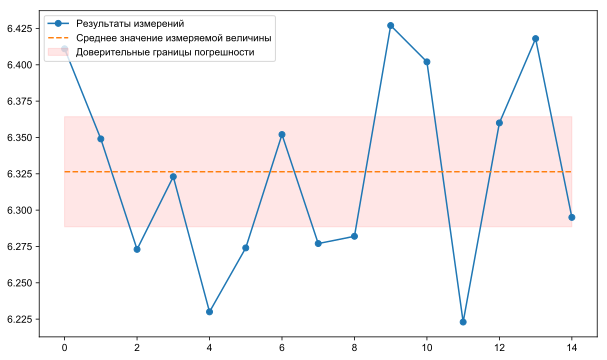

In [13]:
_ = plt.plot(np.arange(0, y.size), y, 'o-')
_ = plt.plot(np.arange(0, y.size), [y.mean()]*y.size, '--')
_ = plt.fill_between(np.arange(0, y.size), y.mean() - delta, y.mean() + delta, alpha=0.1, color='r')
_ = plt.legend(["Результаты измерений", "Среднее значение измеряемой величины", "Доверительные границы погрешности"])